In [1]:
from netCDF4 import Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from cartoplot import cartoplot
import tqdm
from regrid import regrid
import mask
import pickle

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
data_dir = '/media/robbie/TOSHIBA EXT/nsidc_cdr_conc'

In [89]:
def get_fname_month(year,month):
    
    if (year == 1988) & (month == 1): month = 2
    
    date_str = f'{year}{str(month).zfill(2)}'
    
    myfile = 0
    for file in files:
        if date_str in file: myfile = file
    
    if myfile == 0:
        print(year)
        print(month)
        print(date_str)
        raise
        
    return f'{data_dir}/{myfile}'

def get_conc_month(year,month):

    fname = get_fname_month(year,month)
    
    with Dataset(fname) as d:
        
        code = 'goddard_nt_seaice_conc_monthly' if (year ==1987)&(month==12) else 'goddard_merged_seaice_conc_monthly'
        
        try:
        
            sic = np.array(d[code][0]).astype(np.float32)
        except:
            sic = np.array(d['seaice_conc_monthly_cdr'][0]).astype(np.float32)
            
    sic = np.ma.masked_where(sic == 251, sic)
    sic = np.ma.filled(sic,1)
    
    sic = np.ma.masked_where(sic>100, sic)
    sic = np.ma.masked_where(sic<=0, sic)
    sic = np.ma.filled(sic,np.nan)
    
    return(sic)

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.6, ACDD-1.3
    title: NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration Version 3
    references: Comiso, J. C., and F. Nishio. 2008. Trends in the Sea Ice Cover Using Enhanced and Compatible AMSR-E, SSM/I, and SMMR Data. Journal of Geophysical Research 113, C02S07, doi:10.1029/2007JC0043257. ; Comiso, J. C., D. Cavalieri, C. Parkinson, and P. Gloersen. 1997. Passive Microwave Algorithms for Sea Ice Concentrations: A Comparison of Two Techniques. Remote Sensing of the Environment 60(3):357-84. ; Comiso, J. C. 1984. Characteristics of Winter Sea Ice from Satellite Multispectral Microwave Observations. Journal of Geophysical Research 91(C1):975-94. ; Cavalieri, D. J., P. Gloersen, and W. J. Campbell. 1984. Determination of Sea Ice Parameters with the NIMBUS-7 SMMR. Journal of Geophysical Research 89(D4):5355-5369. ; Cavalieri, D. J., C. l. Parkinson

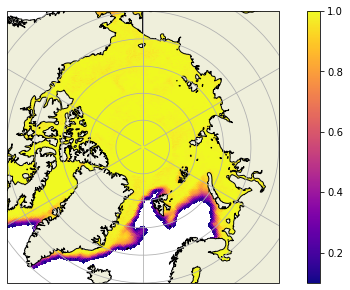

In [65]:
month  = 2
year = 1985

files = os.listdir(data_dir)

d = Dataset(get_fname_month(year,month))

print(d)

conc_lats, conc_lons = np.array(d['latitude']), np.array(d['longitude'])
    
conc = get_conc_month(year,month)

cartoplot(conc_lons, conc_lats, conc)
        

In [3]:
ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

conc_dict = {}

for month in tqdm.tqdm([1,2,12]):
    conc_dict[month] = {}
    
    yearlist = range(1979,2021) if month > 3 else range(1980,2022)
    
    for year in yearlist:
        
        sic = get_conc_month(year,month)
        
        if np.count_nonzero(np.nan_to_num(sic)) < 1000:
            print(month,year)
            raise
        
        sic_ease = regrid(sic,conc_lons,conc_lats,ease_lons,ease_lats)
        
        sic_ease_m = mask.select_region('basin',sic_ease)
        
        conc_dict[month][year] = sic_ease_m

  0%|          | 0/3 [00:00<?, ?it/s]


NameError: name 'get_conc_month' is not defined

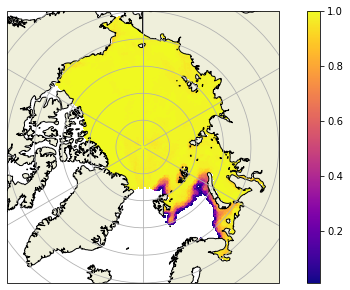

In [95]:
cartoplot(ease_lons,ease_lats,conc_dict[2][2021])

In [93]:
pickle.dump(conc_dict, open('conc_dict.p','wb'))

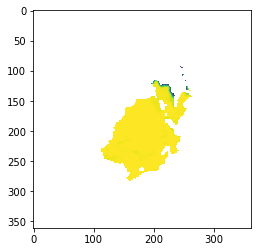

In [83]:
plt.imshow(conc_dict[12][1988])